In [64]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx as nx
import time
import matplotlib.pyplot as plt
import pickle
import numpy as np
from seirsplus.utilities import load_model, save_model, convert_percentage_to_scale
# from seirsplus.networks import prune_graph_per_age
plt.rcParams["figure.figsize"] = (12, 6)
import pandas as pd
import os
from scipy.interpolate import interp1d


In [65]:
vacc_data = pd.read_csv("../israel_data/vaccination_data_for_simulation.csv")


In [66]:
def get_cmap(n=20, map_str= 'hsv'):
    cmap = plt.get_cmap(map_str)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

In [67]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [69]:
folder = 'C:\\Users\\SPO1HFA\\prediction_model\\Code_seir\\g_third_lockdown\\2021_04_13\\''

SyntaxError: EOL while scanning string literal (<ipython-input-69-560058e6631f>, line 1)

<ipython-input-88-ef1376a22675>:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  input_df = pd.DataFrame(np.array(data['relevant_data']), columns = relevant_keys)


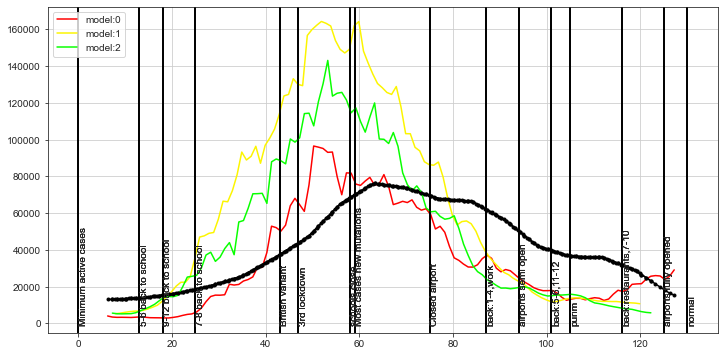

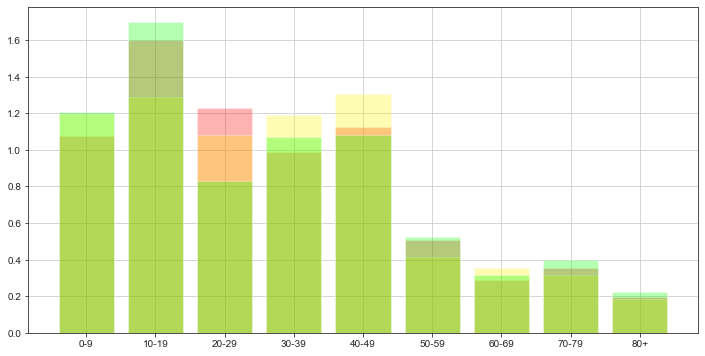

<Figure size 864x432 with 0 Axes>

In [88]:
N = 10000
files_name = os.listdir("C:\\Users\\SPO1HFA\\prediction_model\\Code_seir\\g_third_lockdown\\2021_04_13\\")
colors = get_cmap(len(files_name))
fig, ax = plt.subplots(1, 1)
fig1, ax1 = plt.subplots(1, 1)
times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

time = numpy.load('g_third_lockdown/time_3rd_wave.npy')
active_cases = numpy.load('g_third_lockdown/active_cases_3rd_wave.npy')



#subfolders = [f.path for f in os.scandir("g_third_lockdown/test_coeffs") if f.is_dir()]
data = {'model': [], 'input_config': [], 'relevant_data': []}
relevant_keys = ['airport', 'two_grades', 'pre_school', 'restaurants', 'work', 'starting_prec', 'holiday', 'quarantine_per', 'normal', 'max_value','R0_factor','percentage_out']
plt.figure()
directory ='g_third_lockdown' +("/")+'2021_04_13'
for i in range(int(len(files_name)/2)):
    max_time = 130
    
    config_name = "input_config"+str(i)
    path_name_config = f"{directory}/{config_name}"
    
    model_name = "model"+str(i)
    path_name_model = f"{directory}/{model_name}"
    
    with open(f"{path_name_config}.pickle", 'rb') as handle:
        config_load=  pickle.load(handle)
        
    
    with open(f"{path_name_model}.pickle", 'rb') as handle:
        model_load=  pickle.load(handle)
    
    
    relevant_input = [config_load[k] for k in relevant_keys]

    
    data['model'].append(model_load)
    data['input_config'].append(config_load)
    
    time_ind = np.where(data['model'][i].tseries<=max_time)[0]
    
    
    model_data = (((data['model'][i].numI_sym+data['model'][i].numH)*9e6)/N)[time_ind]
    time_to_plot = data['model'][i].tseries[time_ind]
    
    smooth_model = moving_average(model_data, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))
    smooth_time = moving_average(time_to_plot, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))
    
    max_time = np.min([max_time, smooth_time.max()-1])
    min_time = smooth_time.min()+1
    time_scale = np.arange(min_time, max_time, 1)
    f_real_data = interp1d(time, active_cases)
    real_data = f_real_data(time_scale)
    f_model = interp1d(smooth_time, smooth_model)
    model_out = f_model(time_scale)
    ax.plot(time_scale, model_out, color=colors[i], label=f'model:{i}')
    for t, e in zip(times_for_sim, event):
        ax.axvline(int(t), 0, 1, c='k')
        ax.text(int(t)+0.1, 0, str(e), rotation=90)
    ax.plot(time_scale, real_data, '-k', marker='.')
    model_diff = np.linalg.norm((model_out - real_data)/time_to_plot.size)
    relevant_input.append(model_diff)
    relevant_input.append(i)
    
    #                   [0-9,  10-19,20-29,30-39,40-49,50-59,60-69,70-79, 80+]
    age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
    x_k = []
    y_m = []
    for num, key in enumerate(data['model'][i].nodeGroupData.keys()):
        num_nodes = data['model'][i].nodeGroupData[key]['nodes'].size
        per_pop = num_nodes/N
        mean_age = np.mean(data['model'][i].nodeGroupData[key]['numPositive']/(data['model'][i].numPositive+1e-5))
        x_k.append(key)
        y_m.append((mean_age/per_pop).astype(float))
#         print(f"age:{key}, per real:{age_dist[num]}, per sim:{per_pop}")
#         y_m.append((mean_age/age_dist[num]).astype(float))
#     ax1.scatter(x_k,y_m, color=colors[i], marker='x')
    ax1.bar(x_k,y_m, color=colors[i], alpha=0.3)
#     relevant_input.append(np.array(y_m))
    data['relevant_data'].append(relevant_input)
ax.legend()
relevant_keys.append('model_diff')
relevant_keys.append('folder_num')
ax1.grid()
ax.grid()

input_df = pd.DataFrame(np.array(data['relevant_data']), columns = relevant_keys)

In [87]:
input_df

,airport,two_grades,pre_school,restaurants,work,starting_prec,holiday,quarantine_per,normal,max_value,R0_factor,percentage_out,model_diff,folder_num
0,5,5,8,8,12,59,3,90,18,92,1.71264,"[56.24050632911392, 50.41772151898734, 44.5949...",17.1243,0
1,3,5,12,6,13,76,4,86,0,81,1.46714,"[43.50819672131147, 36.868852459016395, 30.229...",24.8986,1
2,3,10,8,5,14,53,8,90,4,90,1.33954,"[53.375, 42.125, 30.874999999999996, 19.625, 1...",20.9362,2


In [63]:
input_df.iloc[5,input_df.columns=='percentage_out'].values[0]

array([51.31578947, 45.        , 38.68421053, 32.36842105, 32.36842105,
       73.42105263, 79.73684211, 79.73684211, 79.73684211, 61.84210526,
       61.84210526, 49.21052632, 41.84210526, 25.        , 25.        ,
        5.        , 90.        ])

In [7]:
# [(k,data['input_config'][23][k]) for k in data['input_config'][23].keys() if k not in ['beta_values', 'beta_q_values','Q_GLOBALINTXN','P_GLOBALINTXN', 'checkpoint_times']]

In [8]:
data['model'][21].numE[0] * 9*10**6 / N, (data['model'][21].numI_sym[0] * 9*10**6 / N ), 900/990

(8100.0, 9900.0, 0.9090909090909091)

In [9]:
# self.S = 1
# self.E = 2
# self.I_pre = 3
# self.I_sym = 4
# self.I_asym = 5
# self.H = 6
# self.R = 7
# self.F = 8
# self.Q_S = 11
# self.Q_E = 12
# self.Q_pre = 13
# self.Q_sym = 14
# self.Q_asym = 15
# self.Q_R = 17

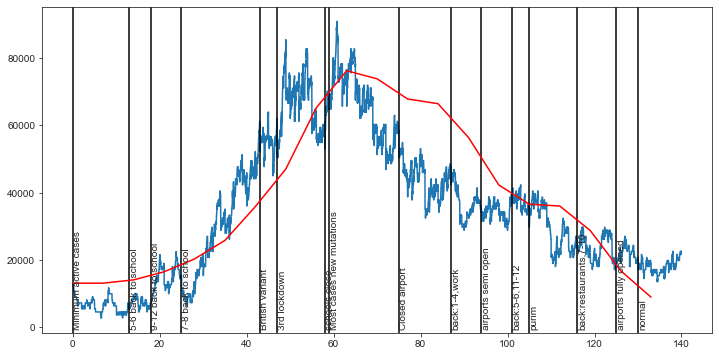

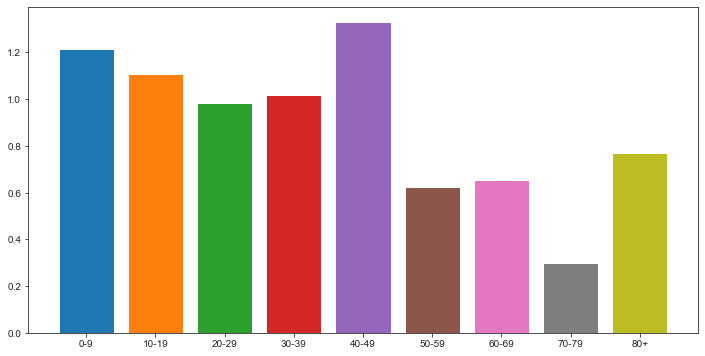

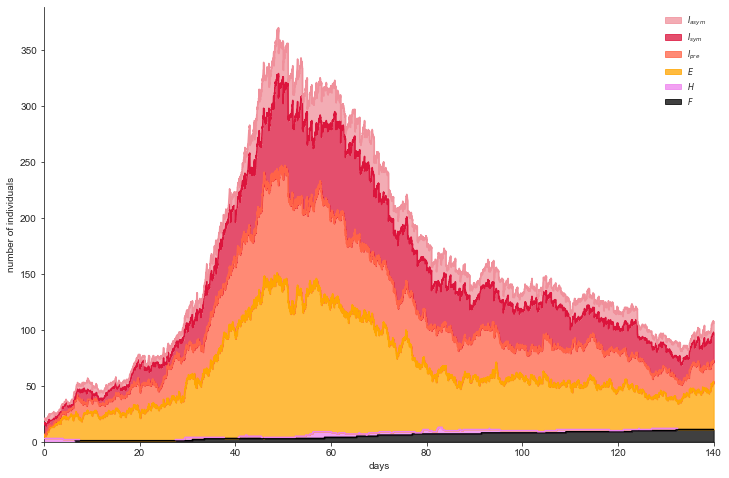

array([0.09090909, 0.18181818, 0.27272727, ..., 1.68      , 1.72      ,
       1.68      ])

In [52]:
# time_line = [5, 30, 60, 90, 115, 120, 137, 150, 160]
# events = ['hofesh gadol', 'close <50,20', 'close work', 'schools back', 'full seger', 'maximum-72k',
#          'kindergarden back', 'grades 1-4 back', 'minimum-8000']
model_2 = data['model'][5]
times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
         '7-8 back to school', 'British variant', '3rd lockdown',
         'schools close', 'Most cases new mutations', 'Closed airport',
         'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
         'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

plt.plot(model_2.tseries, ((model_2.numI_sym+model_2.numH)*9e6)/N)
for time, event in zip(times_for_sim, event):
    plt.axvline(int(time), 0, 1, c='k')
    plt.text(int(time)+0.1, 0, str(event), rotation=90)

time = numpy.load('g_third_lockdown/time_3rd_wave.npy')
active_casese = numpy.load('g_third_lockdown/active_cases_3rd_wave.npy')
plt.plot(time, active_casese, '-r')
plt.show()

age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
for num, key in enumerate(model_2.nodeGroupData.keys()):
    mean_age = np.mean(model_2.nodeGroupData[key]['numPositive']/(model_2.numPositive+1e-5))
    plt.bar(key,(mean_age/age_dist[num]).astype(float))
plt.show()

fig, ax = model_2.figure_infections(combine_Q_infected=False)
plt.show()
model_2.numE /model_2.numI_sym

NameError: name 'subfolders' is not defined

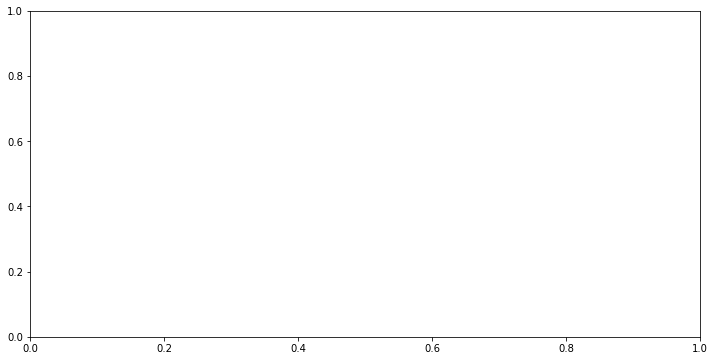

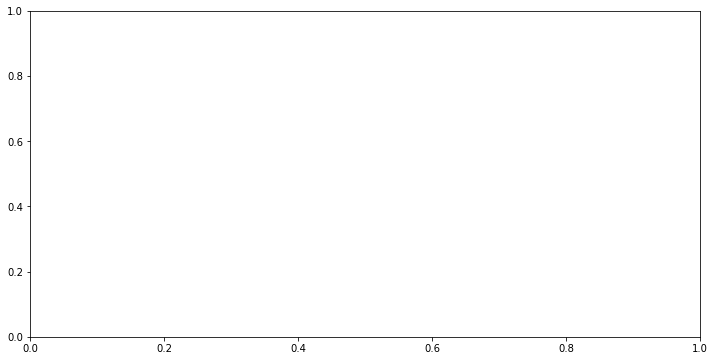

<Figure size 864x432 with 0 Axes>

In [35]:
N = 10000
colors = get_cmap(30)
fig, ax = plt.subplots(1, 1)
fig1, ax1 = plt.subplots(1, 1)
times_for_sim = np.array([160, 173, 178, 185, 203, 207, 218, 219, 235, 247, 254, 261, 265, 276, 285, 290]) - 160
event = ['Minimum active cases', '5-6 back to school', '9-12 back to school',
             '7-8 back to school', 'British variant', '3rd lockdown',
             'schools close', 'Most cases new mutations', 'Closed airport',
             'back:1-4,work', 'airports semi open', 'back:5-6,11-12',
             'purim', 'back:restaurants,7-10', 'airports fully opened', 'normal']

time = numpy.load('g_third_lockdown/time_3rd_wave.npy')
active_cases = numpy.load('g_third_lockdown/active_cases_3rd_wave.npy')



#subfolders = [f.path for f in os.scandir("g_third_lockdown/test_alpha") if f.is_dir()]
data = {'model': [], 'input_config': [], 'relevant_data': []}
relevant_keys = ['airport', 'two_grades', 'pre_school', 'restaurants', 'work', 'starting_prec', 'holiday', 'quarantine_per', 'normal','percentage_out']
plt.figure()
for i, s in enumerate(subfolders):
    max_time = 130
    data['model'].append(load_model(f"{s}/model_out"))
    with open(f"{s}/input_config.pickle", 'rb') as handle:
        input_data = pickle.load(handle)
    relevant_input = [input_data[k] for k in relevant_keys]
    data['input_config'].append(input_data)
    
    time_ind = np.where(data['model'][i].tseries<=max_time)[0]
    
    
    model_data = (((data['model'][i].numI_sym+data['model'][i].numH)*9e6)/N)[time_ind]
    time_to_plot = data['model'][i].tseries[time_ind]
    
    smooth_model = moving_average(model_data, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))
    smooth_time = moving_average(time_to_plot, np.ceil(data['model'][i].numI_sym.shape[0] / 100).astype(int))
    
    max_time = np.min([max_time, smooth_time.max()-1])
    min_time = smooth_time.min()+1
    time_scale = np.arange(min_time, max_time, 1)
    f_real_data = interp1d(time, active_cases)
    real_data = f_real_data(time_scale)
    f_model = interp1d(smooth_time, smooth_model)
    model_out = f_model(time_scale)
    ax.plot(time_scale, model_out, color=colors[i], label=f'model:{i}')
    for t, e in zip(times_for_sim, event):
        ax.axvline(int(t), 0, 1, c='k')
        ax.text(int(t)+0.1, 0, str(e), rotation=90)
    ax.plot(time_scale, real_data, '-k', marker='.')
    model_diff = np.linalg.norm((model_out - real_data)/time_to_plot.size)
    relevant_input.append(model_diff)
    relevant_input.append(s)
    data['relevant_data'].append(relevant_input)
    #                   [0-9,  10-19,20-29,30-39,40-49,50-59,60-69,70-79, 80+]
    age_dist = np.array([0.197,0.181,0.135,0.123,0.121,0.084,0.081,0.050,0.028])
    x_k = []
    y_m = []
    for num, key in enumerate(data['model'][i].nodeGroupData.keys()):
        num_nodes = data['model'][i].nodeGroupData[key]['nodes'].size
        per_pop = num_nodes/N
        mean_age = np.mean(data['model'][i].nodeGroupData[key]['numPositive']/(data['model'][i].numPositive+1e-5))
        x_k.append(key)
        y_m.append((mean_age/per_pop).astype(float))
#         print(f"age:{key}, per real:{age_dist[num]}, per sim:{per_pop}")
#         y_m.append((mean_age/age_dist[num]).astype(float))
#     ax1.scatter(x_k,y_m, color=colors[i], marker='x')
    ax1.bar(x_k,y_m, color=colors[i], alpha=0.3)
ax.legend()
relevant_keys.append('model_diff')
relevant_keys.append('folder_num')
ax1.grid()
ax.grid()

input_df = pd.DataFrame(np.array(data['relevant_data']), columns = relevant_keys)

In [13]:
alone_parma = 0.3
couples_without_kids_param = 0.85
kids_left_house_p = 0.36
old_kids = 0.3
two_kids_young = 0.28
two_kids_old = 0.032

three_kids_young = 0.37
three_kids_old = 0.1

four_kids_young = 0.37
four_kids_old = 0.1

number_of_people_each_household = [1, 4, 4, 2, 2, 3, 3, 4, 5, 8]
households_data = \
    {
    'alone': {0.05 * 0.9: [0, 0, alone_parma/2, alone_parma/2, 0, 0 * (1 - alone_parma) / 8,3 * (1 - alone_parma) / 8,2 * (1 - alone_parma) / 8, 3 * (1 - alone_parma) / 8]},
    'students_app': {0.05 * 0.1: [0, 0.2, 0.8, 0, 0, 0, 0, 0, 0]},
    'soldier': {0.015: [0.0, 0.8, 0.2, 0, 0, 0, 0, 0, 0]},
    'couples_without_kids': {0.935 * 0.28 * 0.25: [0, 0, couples_without_kids_param, 1 - couples_without_kids_param, 0, 0, 0, 0, 0]},
    'couples_kids_left_the_house': {0.935 * 0.28 * 0.75: [0, 0, 0, 0, 0, kids_left_house_p, 16 * (1 - kids_left_house_p) / 30,10 * (1 - kids_left_house_p) / 30, 4 * (1 - kids_left_house_p) / 30]},
    'couples_with_one_young_kid': {0.935 * 0.18 * 0.9: [0.7, 0.3, 0.5, 0.5, 0, 0, 0, 0, 0]},
    'couples_with_one_old_kid': {0.935 * 0.18 * 0.1: [0.0, 1.0, 0.0, old_kids, 1 - old_kids, 0, 0, 0, 0]},
    'couples_with_two_kid': {0.935 * 0.19: [0.5, 0.45, 0.05, two_kids_young, 1 - two_kids_young - two_kids_old, two_kids_old, 0, 0, 0]},
    'couples_with_three_kid': {0.935 * 0.17: [0.5, 0.45, 0.05, three_kids_young, 1 - three_kids_old - three_kids_young, three_kids_old, 0,0, 0]},
    'couples_with_four_kid_pluse': {0.935 * 0.18: [0.5, 0.45, 0.05, three_kids_young, 1 - three_kids_old - three_kids_young, three_kids_old, 0,0, 0]},
}
households_data

{'alone': {0.045000000000000005: [0,
   0,
   0.15,
   0.15,
   0,
   0.0,
   0.26249999999999996,
   0.175,
   0.26249999999999996]},
 'students_app': {0.005000000000000001: [0, 0.2, 0.8, 0, 0, 0, 0, 0, 0]},
 'soldier': {0.015: [0.0, 0.8, 0.2, 0, 0, 0, 0, 0, 0]},
 'couples_without_kids': {0.06545000000000001: [0,
   0,
   0.85,
   0.15000000000000002,
   0,
   0,
   0,
   0,
   0]},
 'couples_kids_left_the_house': {0.19635000000000002: [0,
   0,
   0,
   0,
   0,
   0.36,
   0.3413333333333333,
   0.21333333333333335,
   0.08533333333333333]},
 'couples_with_one_young_kid': {0.15147000000000002: [0.7,
   0.3,
   0.5,
   0.5,
   0,
   0,
   0,
   0,
   0]},
 'couples_with_one_old_kid': {0.01683: [0.0, 1.0, 0.0, 0.3, 0.7, 0, 0, 0, 0]},
 'couples_with_two_kid': {0.17765: [0.5,
   0.45,
   0.05,
   0.28,
   0.688,
   0.032,
   0,
   0,
   0]},
 'couples_with_three_kid': {0.15895: [0.5,
   0.45,
   0.05,
   0.37,
   0.53,
   0.1,
   0,
   0,
   0]},
 'couples_with_four_kid_pluse': {0.1683:

In [101]:
data_pol

,Unnamed: 0,name,description,tagsCsv,time,group
0,0,תחילת הסגר הרשמי,"מגבלת מרחק של 100 מטרים מהבית, פעילויות חיוניו...",NaN,2020-03-19,NaN
1,1,פסח בסגר,פסח בבית (7–16 באפריל) בחברת המשפחה הגרעינית ב...,NaN,2020-04-07,NaN
2,2,מקומות הבילוי והפנאי נפתחים מחדש,"צמצום ההגבלות, פתיחה מחדש של חנויות הרחוב, פתי...",NaN,2020-04-24,NaN
3,3,חזרה חלקית ללימודים,"תלמידי כיתות א'-ג', י""א-י""ב חוזרים ללמוד בקפסו...",NaN,2020-05-03,NaN
4,4,חידוש התפילות והפעילות בבריכות השחייה,"פתיחה של ספריות, מלונות, פארקים ציבוריים, גני ...",NaN,2020-05-04,NaN
5,5,הקניונים נפתחים מחדש,שיעור הבדיקות החיוביות הממוצע ל-7 ימים: 0.75%,NaN,2020-05-07,NaN
6,6,גני הילדים נפתחים מחדש,שיעור הבדיקות החיוביות הממוצע ל-7 ימים: 0.60%,NaN,2020-05-10,NaN
7,7,"חזרה ללימודים, ללא קפסולות","כולם חוזרים ללימודים, הקפסולות מבוטלות (חזרה ל...",NaN,2020-05-17,NaN
8,8,חובת המסכות מבוטלת זמנית בשל שרב כבד,חובת המסכות בחוץ ובכיתות מבוטלת עקב שרב כבד מ-...,NaN,2020-05-19,NaN
9,9,"המסעדות, המועדונים ובתי המלון נפתחים מחדש","פתיחה מחודשת של מסעדות, מועדונים, בתי מלון, בר...",NaN,2020-05-27,NaN
